<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/17.UCB_P%3D40_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 40 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-10-28 03:23:34--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-10-28 03:23:34--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd1559eeb5c36d696a8a645a3df.dl.dropboxusercontent.com/cd/0/inline/BY2e_uO9CB1BTu63i088-g0eTiw7mUmn2UeuOeMFzooaJTpkWvgROzQgqlBvtEIR1g2EBRvleu1K4-iy_knzbDGvIa2JtBqX9xX5fDo80XjU5bXUUQo7J7A_6l2Tl5-XoFOvZt4oCww4z2VRkizy9ONF/file# [following]
--2021-10-28 03:23:35--  https://ucd1559eeb5c36d696a8a645a3df.dl.dr

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-10-28 03:23:37--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-10-28 03:23:37--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc635476b5edb56ff95f11da321b.dl.dropboxusercontent.com/cd/0/inline/BY3Uo4Ohb7zJIIP1J72U2oOTKFWHqx46B6Gy06tMgz0H4vcvJ9ieUFw10IxLFDB_7907zjl5HObdCaDRrN56YiDQqXwaQl5x7Z9vPbXAcnP-rZdk2KeESBg8gmMLJjX0HwnXgt4eZTglQcMmLQp9583k/file# [following]
--2021-10-28 03:23:38--  https://uc635476b5edb56ff95f11da321b.dl.dropboxusercontent.com/cd/0/inline/BY3Uo4Ohb7zJIIP1J72U2oOTKFWHqx46B6Gy06tMgz0H4vcvJ9ieUFw10IxLFDB_7907zjl5HObdCaDRrN56YiDQqXwaQl5x7Z9vPbXAcnP-

In [6]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def UCBobjective(Xsamples, X, model, beta):
  Xsamples = Xsamples[np.newaxis,:]
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = beta
  probs = mu + sigma * std
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model, iteration):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  if iteration<180:
   beta = 5*np.exp(((-6-np.log(5))*iteration)/180)
  else:
   beta = 5*np.exp(((-6-np.log(5))*180)/180)
  
  for i in range(1):
    result = dual_annealing(UCBobjective, bounds, args=(X,model,beta))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_P=40_3.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_P=40_3.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_P=40_3.npy")

x_next is [ 35.31156992  28.88639671  -3.49368472 -19.7964938  -30.79324567
  -8.84893866 -24.82123151   0.44664476  -2.45241579  20.5947857
  38.21988108 -16.23986013 -16.71740568  14.29569385   8.29309308
   2.84786524   6.17454047   0.20983208  29.07460199 -20.24719362]
f()=55.670436, actual=27.342
0


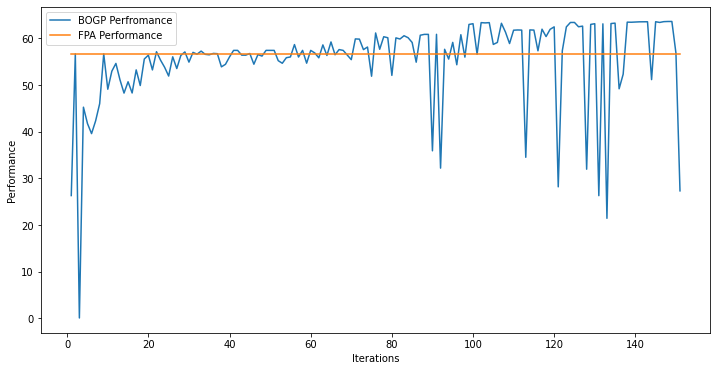

x_next is [ 40.          40.          -0.07076962  25.92957167  40.
  32.54768232  40.          40.          39.99999998 -31.
  39.99999997  39.99999516  39.99993704  40.          40.
  31.14235115  40.          33.3598254   33.69969872  33.06545061]
f()=63.663875, actual=63.722
1


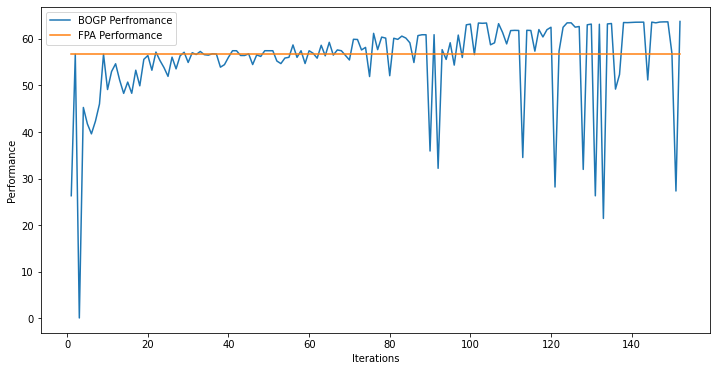

x_next is [ 4.00000000e+01  4.00000000e+01  1.28075914e-02  2.64950192e+01
  4.00000000e+01  3.15466988e+01  4.00000000e+01  4.00000000e+01
  4.00000000e+01 -3.10000000e+01  4.00000000e+01  3.99997571e+01
  4.00000000e+01  4.00000000e+01  4.00000000e+01  3.14894813e+01
  4.00000000e+01  3.27589532e+01  3.34555051e+01  3.38560799e+01]
f()=63.780234, actual=63.828
2


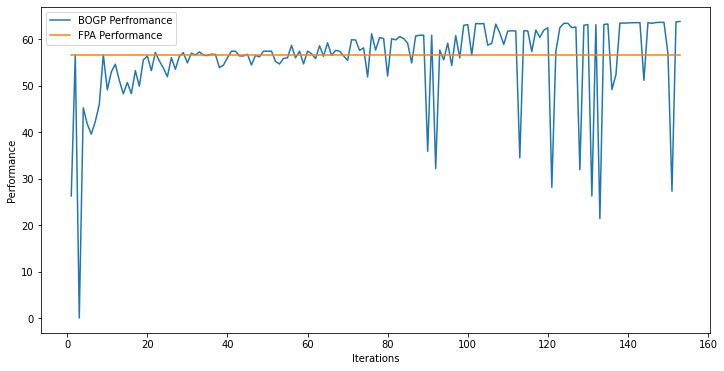

x_next is [ 39.99986666  39.99993856   4.94219455  39.99989527  39.99991851
  39.99960735  39.99980887  39.99999339 -28.6225332   39.99997107
  39.99983963  39.99993012  39.9998065   39.99994415  39.99991355
  39.9997343   39.99998359  35.47371746  39.99998595  39.18790015]
f()=56.584457, actual=55.056
3


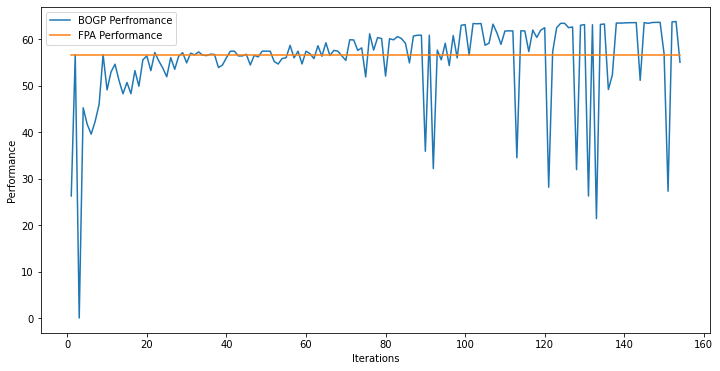

x_next is [ 39.99965587  39.99736132  39.99955698  26.58013647  39.99890672
  34.49533151  39.99976788  39.99586765  39.99882186 -26.84637638
 -24.78292362  39.99965509  39.999996    39.99937135  39.9991736
  30.43115618  39.99776206  39.99842127  31.69917712  33.64228178]
f()=63.428252, actual=63.429
4


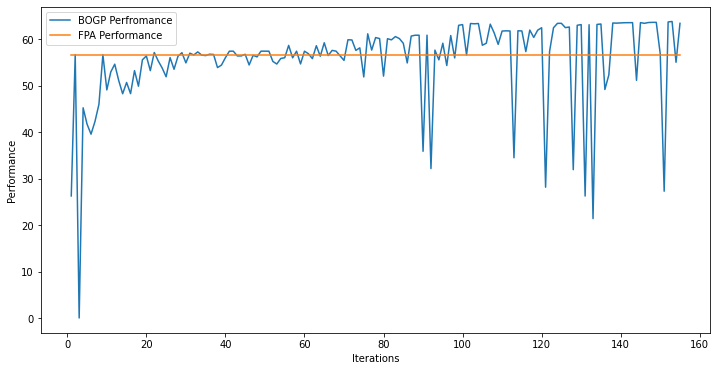

x_next is [ 40.          40.          -0.08874181  26.80890878  40.
  30.79582907  40.          40.          40.         -31.
  40.          39.99999953  40.          40.          40.
  31.65264677  40.          32.2108892   33.40820907  34.07782389]
f()=63.846452, actual=63.839
5


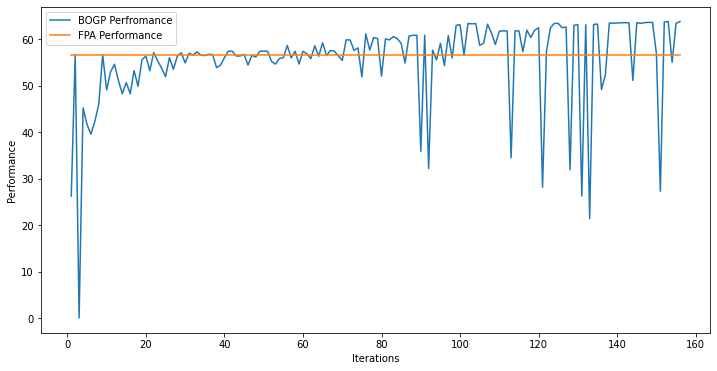

x_next is [ 39.97880446 -30.88649516 -30.98948023  39.91776033  39.96928357
  39.98228422  39.98543103  39.94827992 -30.97070025  39.99955627
 -30.96006819 -30.98196114  39.98342711  39.94177213  39.99863224
  39.94225767  39.99694301  39.96240353  39.82553153  39.95995147]
f()=60.750396, actual=54.662
6


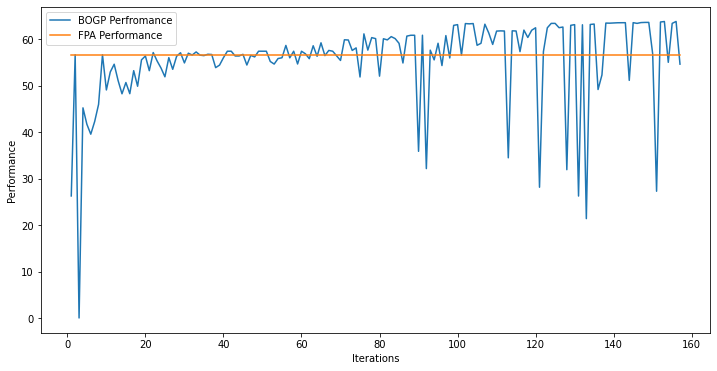

x_next is [ 38.50283695 -28.62772734  39.79883637  32.39621675  36.72746456
  28.13634329 -30.11537588 -29.75173656  38.46594889  38.75741314
 -30.66780855 -30.5430308   39.84814529  39.32307239  39.73345145
  39.41455999  37.73867102  25.4231878   19.50014156  39.85006836]
f()=57.600141, actual=51.411
7


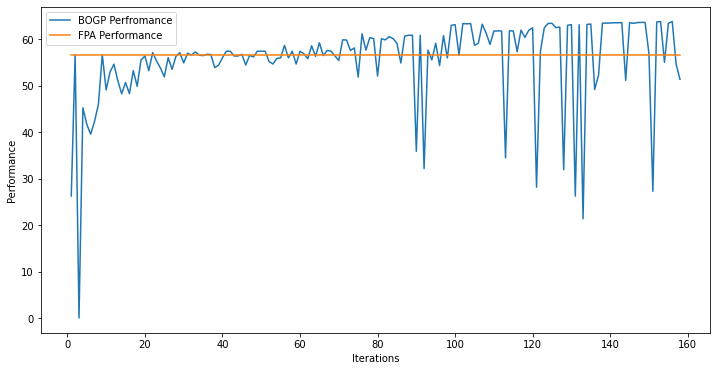

x_next is [ 24.62390726  39.49464804  30.29047412  27.23529584   0.69070838
  -9.14582183   3.17668139  18.18416038 -29.05179257 -22.72867912
  31.13563419 -11.76369887 -14.2582912    8.23290755  -4.66830495
  11.75372127   5.74193573   0.64425186 -26.35575956  24.01974491]
f()=55.656999, actual=30.542
8


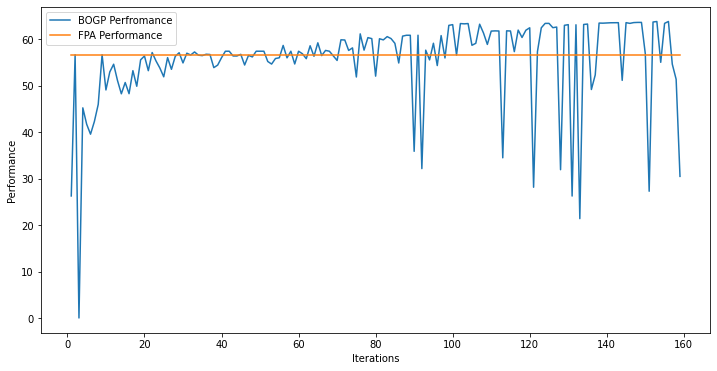

x_next is [ 40.          40.          -0.09240001  26.71094042  40.
  30.95831391  40.          40.          40.         -31.
  40.          40.          40.          40.          40.
  31.62085928  40.          32.40581222  33.40712221  34.10343632]
f()=63.839826, actual=63.844
9


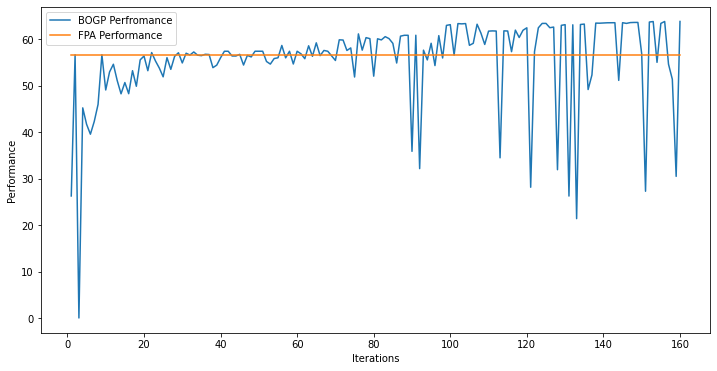

x_next is [ 39.99998905  39.99962089  -0.26644503  26.5848771   39.99972316
  30.93411682  39.99870662  39.99990776  39.99877774 -30.99881926
  39.99804701  39.99986989  39.99888874  39.99949359  39.99986554
  31.56796868  39.9997801   32.57594856  33.37800131  34.29925193]
f()=63.847078, actual=63.853
10


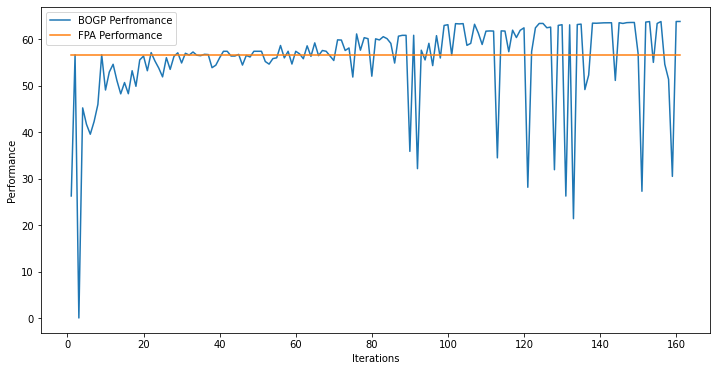

x_next is [ 39.99996189  18.53126613 -30.99949166  30.18355693  39.99986244
  39.99981114  39.99980112  39.99998624  29.13647869  23.13466996
 -30.99961429 -30.99998409  39.99998865  39.99953158  39.99987059
  39.99988462  39.99999229  39.99993385  39.99999789  39.99963993]
f()=57.099435, actual=58.060
11


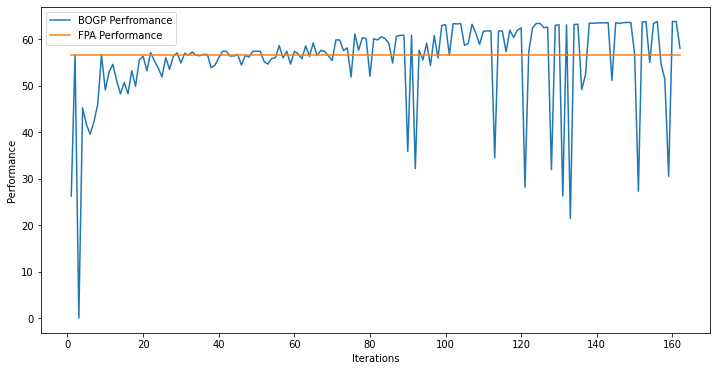

x_next is [ 40.          40.          40.          26.56893511  40.
  34.46803266  40.          40.          40.         -26.85555489
 -24.83161401  40.          40.          40.          40.
  30.4632347   40.          40.          31.675992    33.62706777]
f()=63.429443, actual=63.427
12


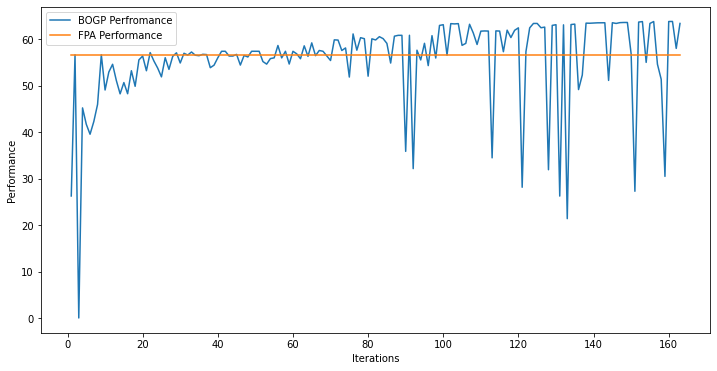

x_next is [ 39.99958209  18.7728791  -30.99973722  28.25996821  39.99960538
  39.99966997  39.99990736  39.99929175  28.68407679  27.95227424
 -30.99992216 -30.99999472  39.9997561   39.99950086  39.99995464
  39.99984559  39.99968788  39.99986882  39.99976967  39.99977829]
f()=58.067243, actual=58.524
13


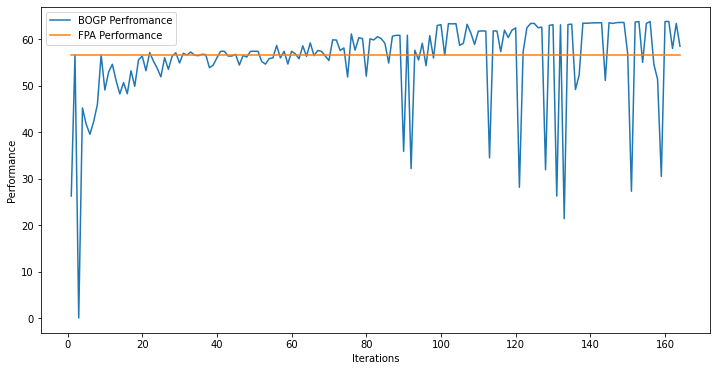

x_next is [ 39.99970567  18.87557509 -30.99997701  17.9124437   39.99943086
  39.99996989  39.99996725  39.99989018  27.61365639  39.99943885
 -30.99987043 -30.99992532  39.99990237  39.99988532  39.99957725
  39.99995978  39.99999043  39.99997068  39.99994059  39.9999451 ]
f()=59.402308, actual=53.581
14


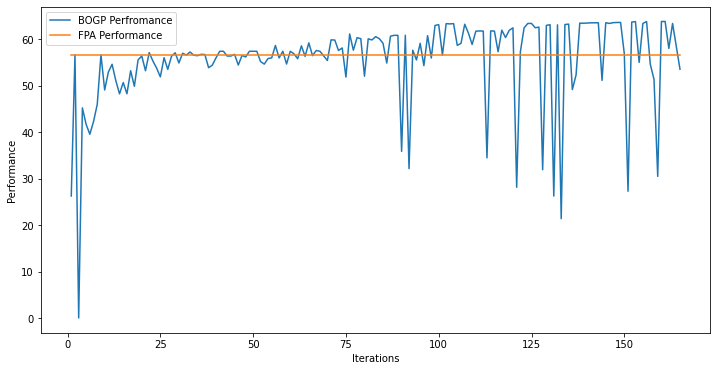

x_next is [ 36.97373959   3.93659986 -15.46863812 -18.4115432  -17.11415674
   8.28300718  27.03523431  20.53148331  11.88738728   5.58941023
   2.98637643   6.93068343  30.51475789  37.17396116   2.01329292
 -24.63841521  -4.30777687   3.30187487   3.93185177 -13.49073885]
f()=55.670362, actual=30.341
15


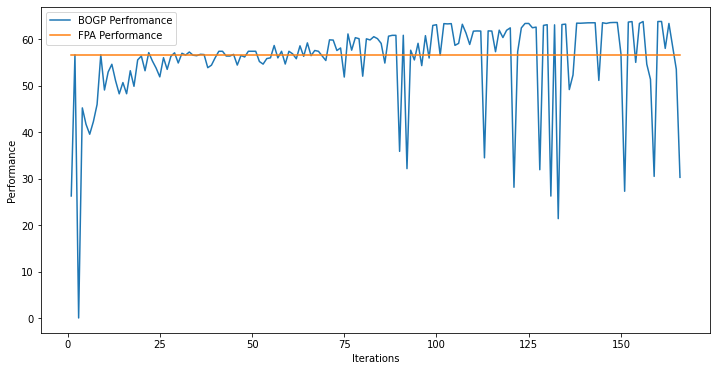

x_next is [ 39.99996794  39.99988675  -0.54794478  26.4205142   39.99970276
  30.83676583  39.99999437  39.99998365  39.99999159 -30.99922484
  39.99999487  39.99794415  39.99998587  39.99998862  39.99999521
  31.41873955  39.99981968  32.62504789  33.32541802  34.43954117]
f()=63.857145, actual=63.857
16


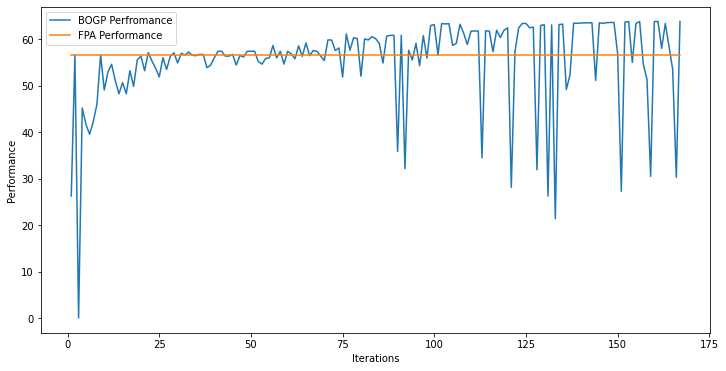

x_next is [ 39.99998832  39.99996286  -0.52449593  26.42050061  39.99986629
  30.84208128  39.99994645  39.99976779  39.99958153 -30.99962937
  39.99865069  39.99967279  39.99998239  39.9999786   39.99986282
  31.4298374   39.99997401  32.63866796  33.34186924  34.43468789]
f()=63.856699, actual=63.857
17


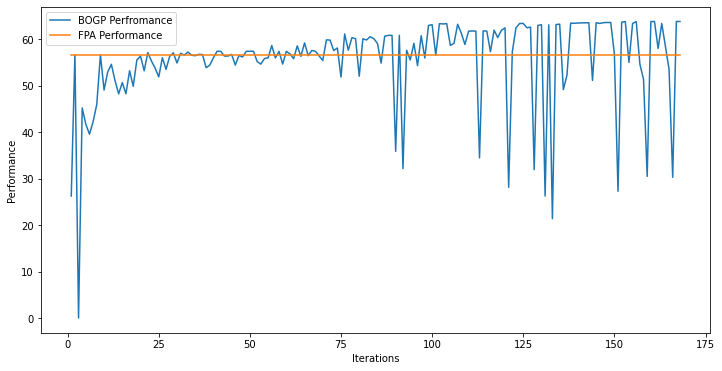

x_next is [ 39.99995959  20.52282952 -30.12173305  39.9999186   39.99978294
  39.9999035   39.99993046  39.99991987  26.01705535  34.75191001
 -30.99948318 -30.99996085  39.99982512  39.99997733  39.99994952
  39.99993284  39.9999306   39.99996811  39.99985866  39.99990663]
f()=60.905116, actual=56.908
18


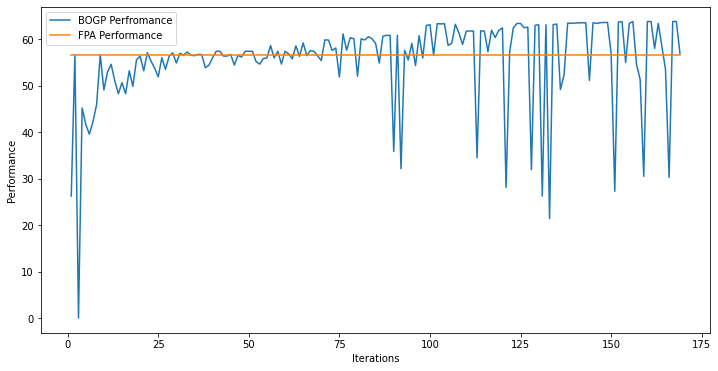

x_next is [ 39.99998517  39.9998282   -0.56076995  26.49701565  39.99973166
  30.86366302  39.99998501  39.99947583  39.99999174 -30.99991875
  39.99948177  39.99998591  39.9999903   39.99998514  39.99998957
  31.41814341  39.999886    32.59754395  33.25929006  34.46352275]
f()=63.857089, actual=63.859
19


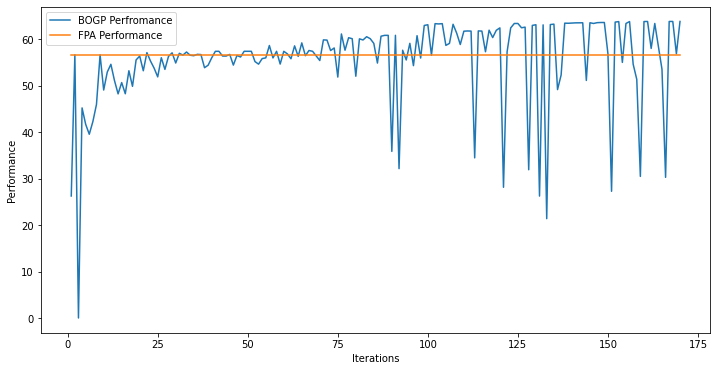

x_next is [ 39.99961952  39.99984369  39.99978459  39.99937756  39.99998614
  39.99991557  39.99987573  39.9996926   39.99984944 -30.99969798
  39.99922144  39.99993784  39.99956665  39.99945247  39.99981503
  39.99978337  39.99972597  39.99964991  39.99998192  39.99957969]
f()=55.672867, actual=57.349
20


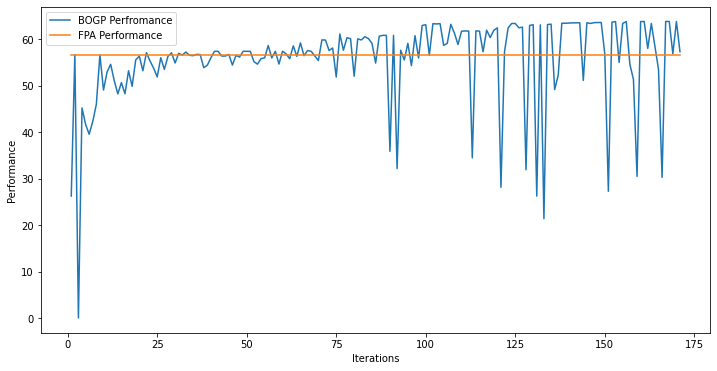

x_next is [ 39.99999834 -30.99990867  39.99988462  39.9997802   39.99999892
  35.90187822  39.99997014  39.9999987   39.99999646  10.02900819
 -30.99983728 -30.99991371  39.99999855  39.99999902  39.99999802
  39.99993283  39.99998032  37.69854831  26.1522276   39.99968383]
f()=57.996379, actual=57.707
21


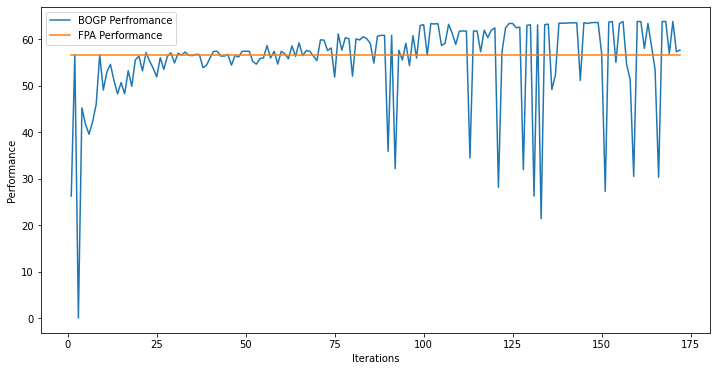

x_next is [ 40.          40.          -0.57195333  26.7338932   40.
  30.93373952  40.          40.          40.         -30.99999998
  39.99999999  39.99935092  40.          40.          40.
  31.39014613  40.          32.66236408  33.17229339  34.63379573]
f()=63.862183, actual=63.864
22


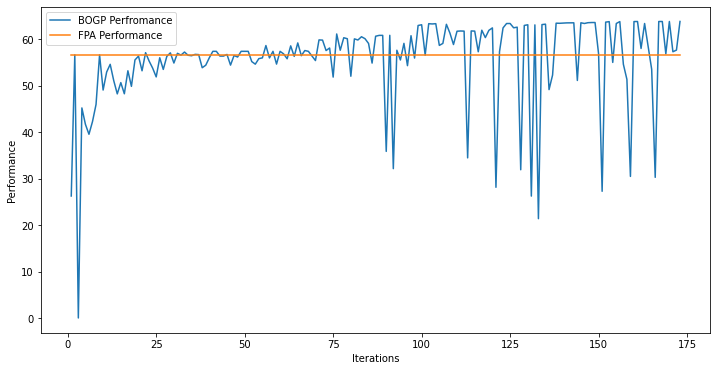

x_next is [ 39.99999617  -9.40300423  39.999872    39.99987939  39.99999403
  38.9769644   39.9997983   39.99977637  39.99999432  18.20086461
 -30.99982608 -30.99999219  39.99990964  39.99972125  39.99999461
  39.9999919   39.99999639  37.4607301   28.32340198  39.99985668]
f()=58.205099, actual=58.699
23


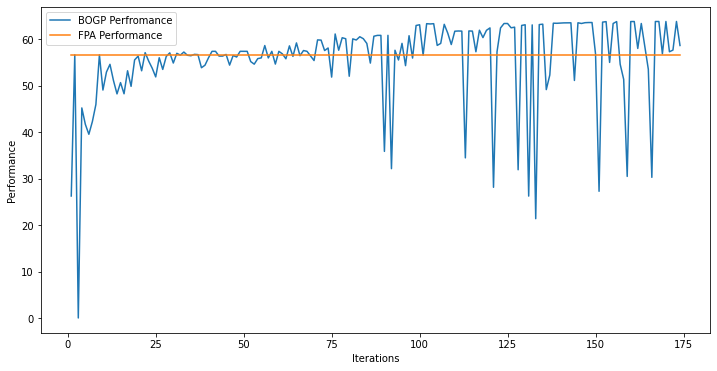

x_next is [ 39.99999991  39.99999991  -0.58541352  26.81663274  39.99999991
  30.92105075  39.9999999   39.9999999   39.99990712 -30.99999987
  39.99999991  39.99999988  39.9999999   39.99999991  39.9999999
  31.34441449  39.9999999   32.69151898  33.1963557   34.70587776]
f()=63.864705, actual=63.865
24


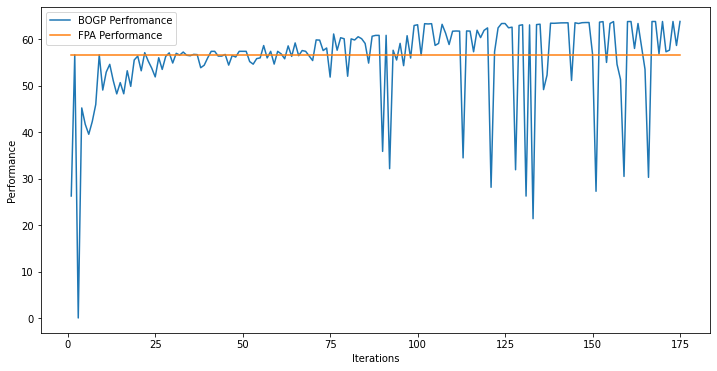

x_next is [ 39.99999295  39.99988195  -0.59499024  26.84510149  39.9999887
  30.93075179  39.9999918   39.99971022  39.99998948 -30.99986878
  39.99999041  39.99999098  39.99999424  39.99999295  39.999993
  31.31309521  39.9999757   32.70920192  33.23535398  34.71229336]
f()=63.865032, actual=63.865
25


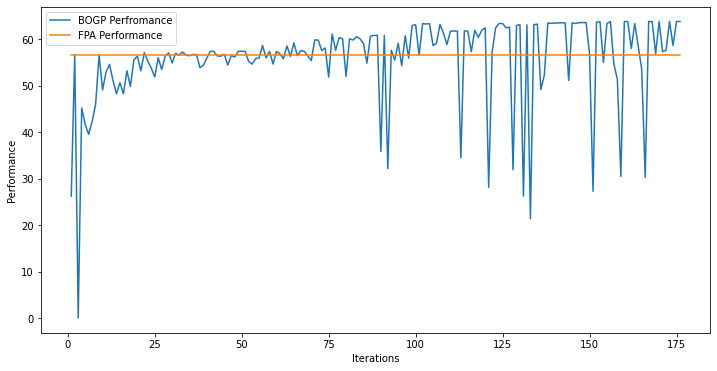

x_next is [ 19.24141002   5.45557396 -26.2643103  -12.50324086 -11.62221586
 -25.62058145 -16.51238664   0.89426795 -14.39397473  -7.95627535
  12.84343097  36.08027214 -23.58244439  -1.66431469 -27.21805981
  11.17337093   9.04526073 -19.33466772  26.18537557  -2.92049575]
f()=55.850991, actual=21.815
26


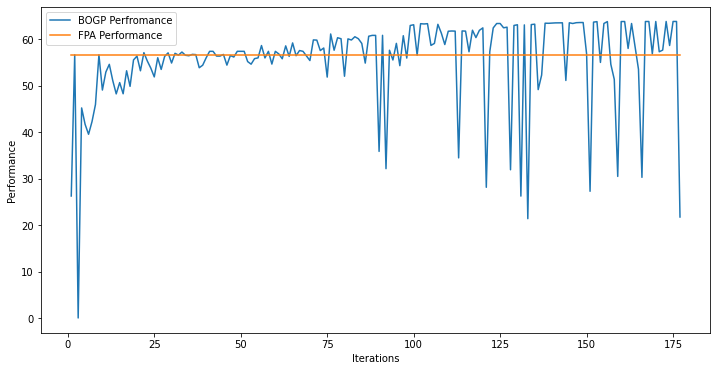

x_next is [ 39.99910355  39.9999941   39.99960665  26.53249846  39.99953972
  34.67748999  39.99861446  39.52348683  39.99834962 -27.03129951
 -24.68434936  39.99979454  39.99999148  39.99999522  39.99974491
  30.03276122  39.99999364  39.99950942  31.74930417  33.67858511]
f()=63.440338, actual=63.575
27


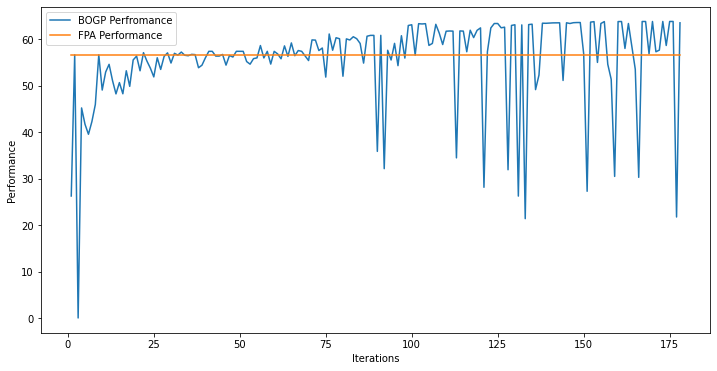

x_next is [ 40.          40.          -0.56252127  26.84249008  40.
  30.90039418  40.          40.          39.99999997 -30.99999997
  39.99999997  40.          40.          40.          40.
  31.33224019  40.          32.68785475  33.20062964  34.74805772]
f()=63.865074, actual=63.865
28


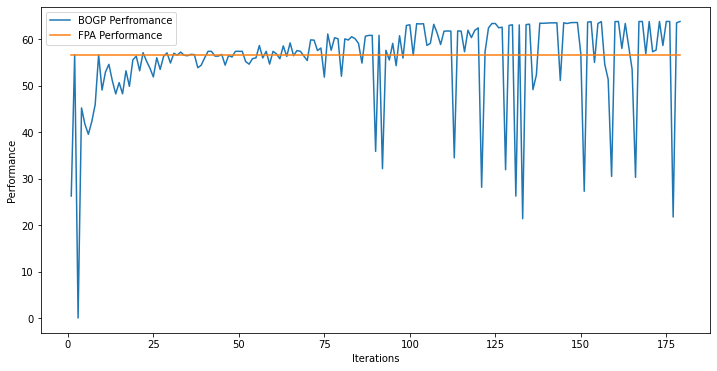

x_next is [ 39.99965255  -4.95325526  39.99999415  39.99985072  39.99996941
  38.20325934  39.99999626  23.39946405  39.99987063  15.40941477
 -30.99986099 -30.99979661  39.99990698  39.99999448  39.99987751
  39.9999949   39.99994087  37.22367003  28.09234438  39.99999289]
f()=58.980392, actual=58.730
29


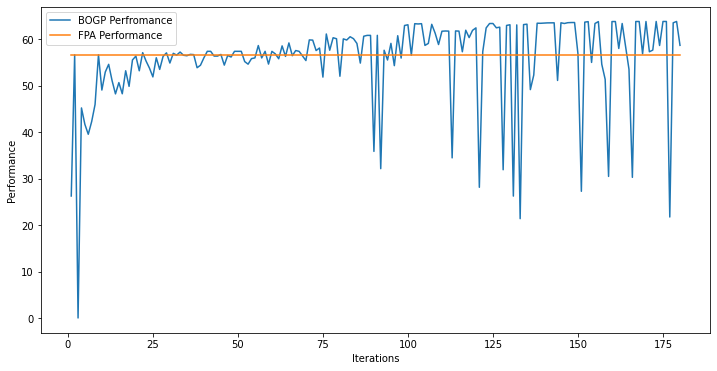

x_next is [ 39.9998403   39.99978114  -0.58183419  26.84658792  39.99988009
  30.89567352  39.9999718   39.99989201  39.99985441 -30.99940384
  39.99946526  39.99932227  39.99986582  39.99983079  39.99991167
  31.33823095  39.99992382  32.69201098  33.18896766  34.74269316]
f()=63.864881, actual=63.865
30


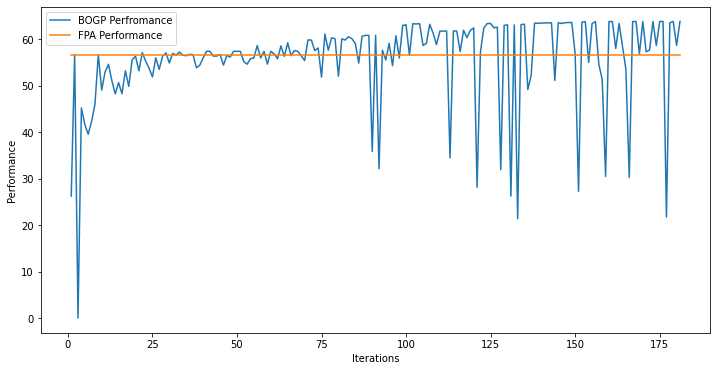

x_next is [ 39.99963306  -6.57917839  39.99964067  39.99974284  39.99999014
  39.35892255  39.99967698  32.25046263  39.9992413   19.48782044
 -30.99967508 -30.99993902  39.99994273  39.99986829  39.99989719
  39.99992503  39.99999955  36.9521624   29.15526216  39.99997689]
f()=58.800613, actual=59.122
31


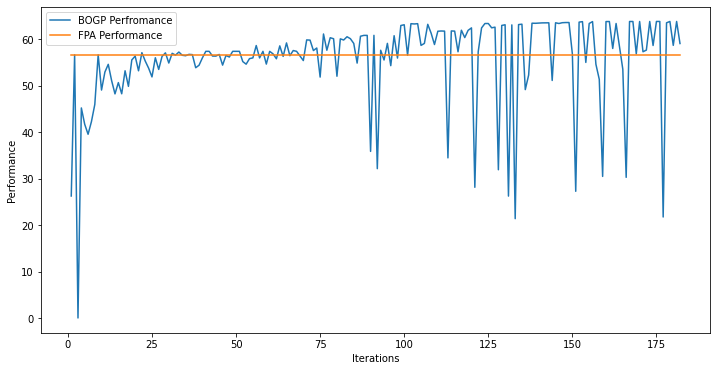

x_next is [ 39.99998285  39.99988019  39.99974774  26.63056694  39.99995664
  35.01536087  39.99992548  28.5652606   39.99991432 -27.15606214
 -25.91775083  39.99995596  39.99979478  39.99997005  39.999997
  29.165344    39.9999991   39.99978237  30.99638045  32.92539403]
f()=64.746067, actual=63.800
32


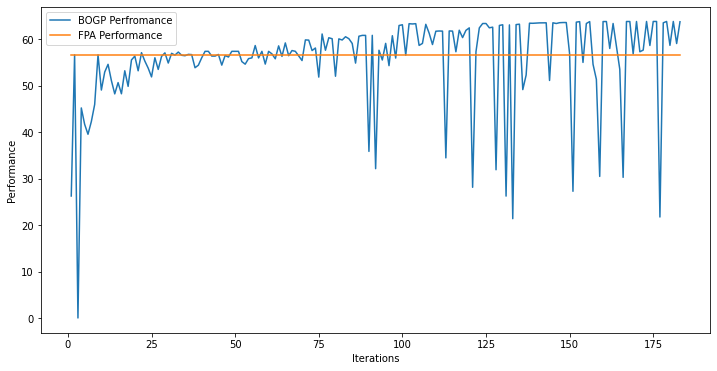

x_next is [ 39.99998754  39.99998994  39.99999368  26.48667973  39.99999392
  34.73852746  39.99992934  34.26014497  39.99998861 -27.27907513
 -24.97141692  39.99999383  39.99992081  39.99999393  39.99999767
  29.74918104  39.99998917  39.99999106  31.79115644  33.29202797]
f()=64.192573, actual=64.288
33


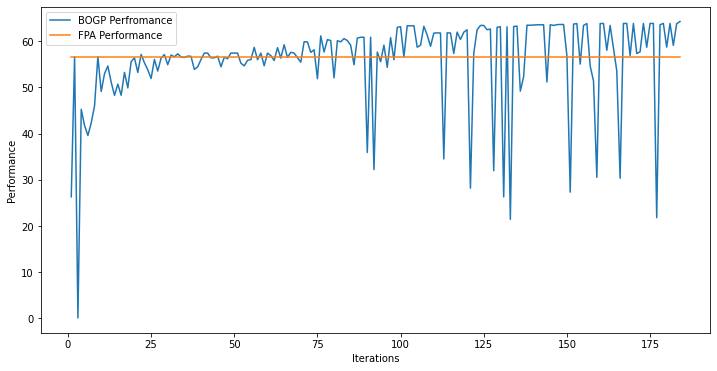

x_next is [ 39.99942673  39.99984591  39.99958591  39.99930508  39.99984416
  39.99993483  39.99969502  39.99936413  39.99967885 -30.99985819
  39.99939351  39.99980081  39.99998362  39.99957718  39.99999567
  39.99921598  39.99975477  39.99973074  39.99994273  39.9995943 ]
f()=55.917161, actual=57.349
34


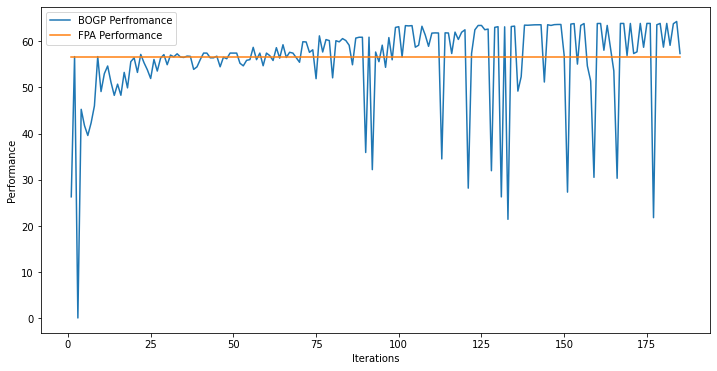

x_next is [ 39.9996348   39.99995771  -0.68569612  26.95817418  39.99973288
  30.75679206  39.99968391  39.99977413  39.99932183 -30.99860722
  39.99893004  39.99985721  39.99955851  39.99861388  39.99968504
  31.40356845  39.99953176  32.76316311  33.13800957  34.67372773]
f()=63.866801, actual=63.866
35


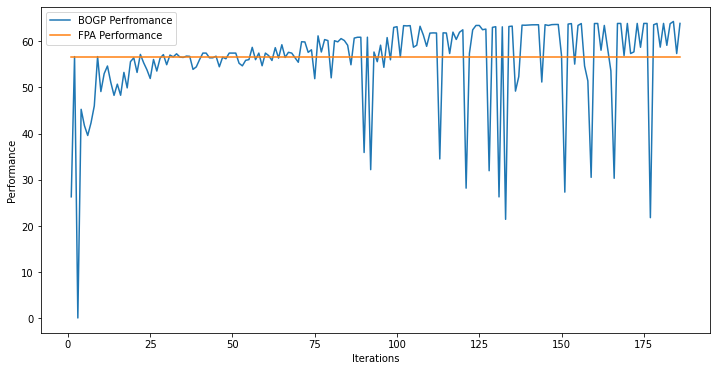

x_next is [ 39.99987248 -30.99926531 -30.94589746 -30.99971147  39.99991195
  39.99786305  39.99983827  39.99992781  39.99970396 -30.99865305
  39.99991013  39.99959777  39.99981239  39.99994919  39.99987223
 -30.99640366  39.9996889   39.99971298 -30.99614547  39.9999962 ]
f()=63.114369, actual=48.187
36


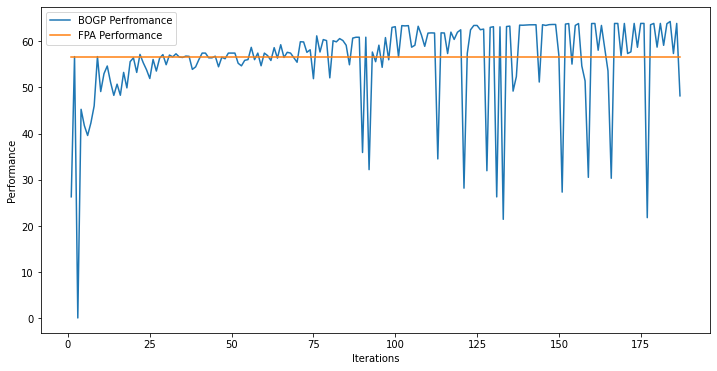

x_next is [ 39.99999129  -8.54209789  39.99996641  39.99999035  39.99991421
  39.99985896  39.99982641  30.09836689  39.99966036  28.67345767
 -30.99950741 -30.99996866  39.99997298  39.99988902  39.99962689
  39.99967614  39.99996912  34.22601401  32.83039032  39.99997914]
f()=59.385773, actual=59.486
37


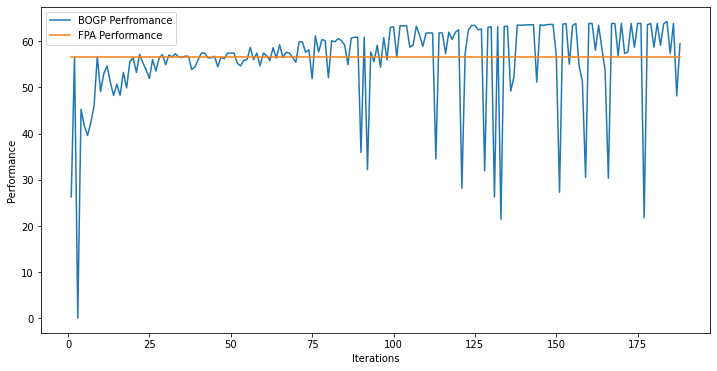

x_next is [ 40.          40.          -0.71395413  26.93371827  40.
  30.8109543   40.          40.          39.99999998 -30.99999988
  39.99999989  39.99999996  40.          39.99999999  40.
  31.41214326  40.          32.7219432   33.14917554  34.75530516]
f()=63.866564, actual=63.866
38


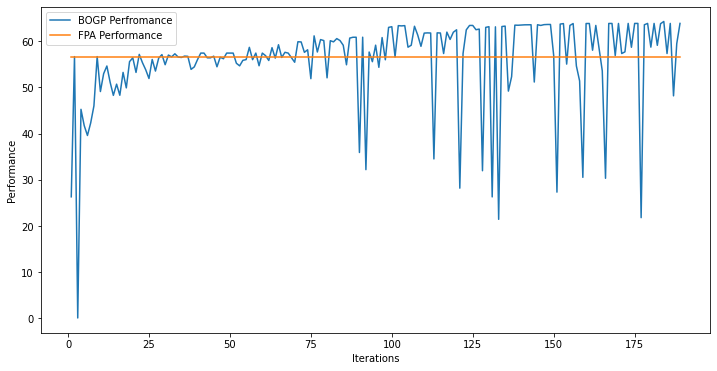

x_next is [ 39.9999871   -9.55744068  39.99989716  39.9990044   39.9997351
  39.99962293  39.99988133  29.74776098  39.99998325  30.3163243
 -30.99654306 -30.99945033  39.99998803  39.99994238  39.99998636
  39.99998952  39.9999629   33.24940284  33.65127133  39.99999178]
f()=59.496124, actual=59.027
39


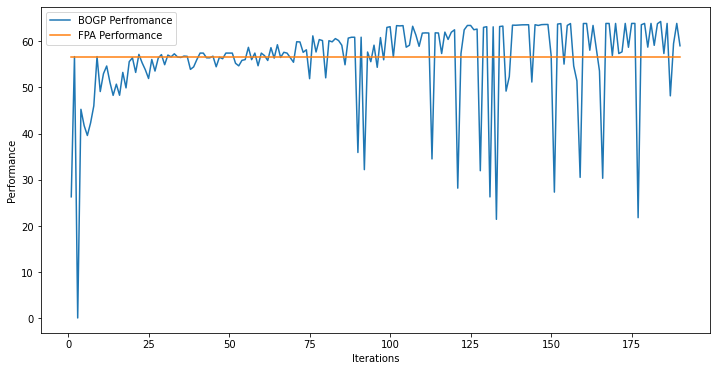

x_next is [ 39.99981535  39.99941368  -0.64715309  26.91290178  39.99984238
  30.79830075  39.99998069  39.99986969  39.99964808 -30.99896117
  39.99712866  39.99967229  39.9995867   39.99968903  39.99971881
  31.31192753  39.99978669  32.76286324  33.10749698  34.67329733]
f()=63.866378, actual=63.866
40


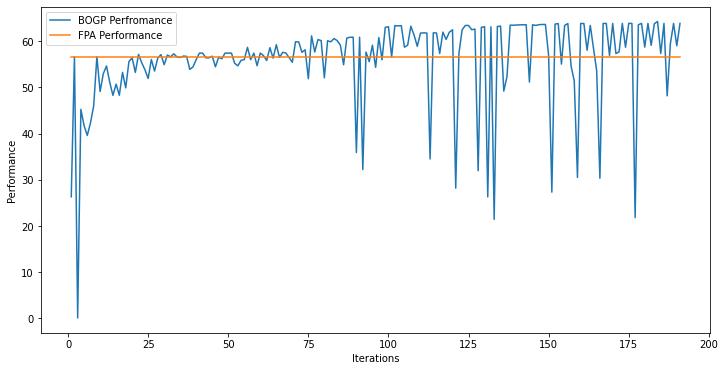

x_next is [ 39.99994537  39.99999999  40.          26.47618379  40.
  34.72058712  39.99999999  34.08694995  40.         -27.26285097
 -24.85916242  39.99997574  40.          39.99999999  40.
  29.82806955  40.          39.99999989  31.82259218  33.34269404]
f()=64.289347, actual=64.283
41


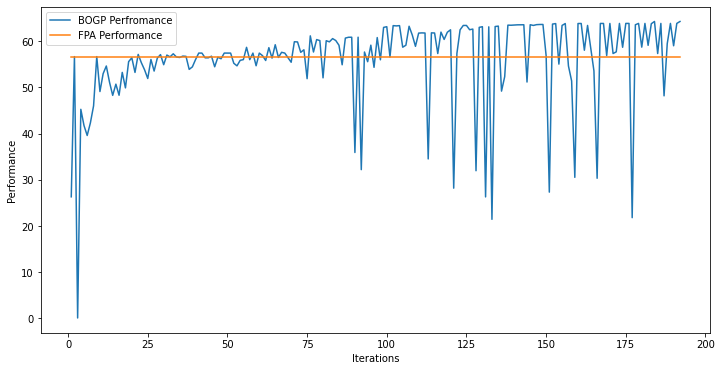

x_next is [ 39.99999999  40.          40.          26.47627808  40.
  34.81406396  40.          34.28647176  40.         -27.3374439
 -25.33363122  40.          40.          40.          40.
  29.54855941  40.          39.99884917  31.7677324   33.17967919]
f()=64.292647, actual=64.293
42


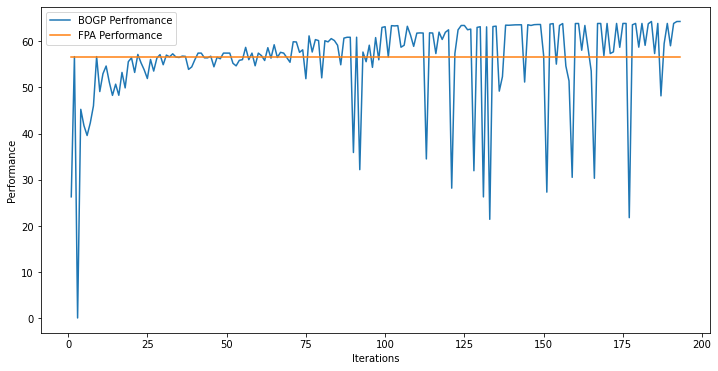

x_next is [ 39.99985128  39.99973626  -0.64748651  26.93594811  39.99994329
  30.79077471  39.99931947  39.99941818  39.99902253 -30.99777021
  39.99912441  39.99603341  39.99928162  39.99981277  39.99874
  31.38323958  39.99984869  32.74751954  33.15778429  34.67287787]
f()=63.865895, actual=63.865
43


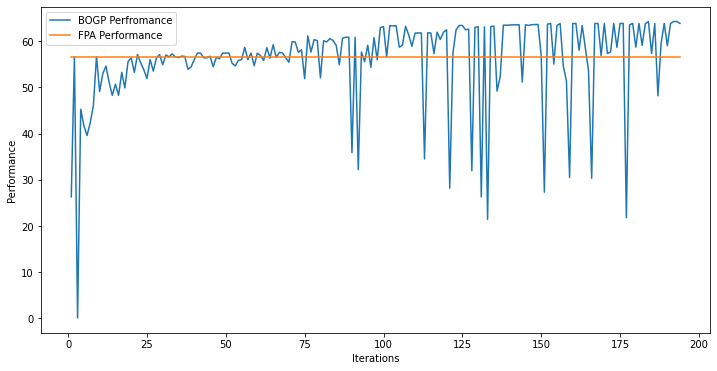

x_next is [ 39.99998247  39.99989787  -0.66957254  26.85908532  39.99930954
  30.85310406  39.99952748  39.99851377  39.99925739 -30.99920269
  39.9808878   39.99989802  39.9999303   39.99971618  39.99918222
  31.37985733  39.99989991  32.7884      33.11587921  34.7195808 ]
f()=63.865732, actual=63.867
44


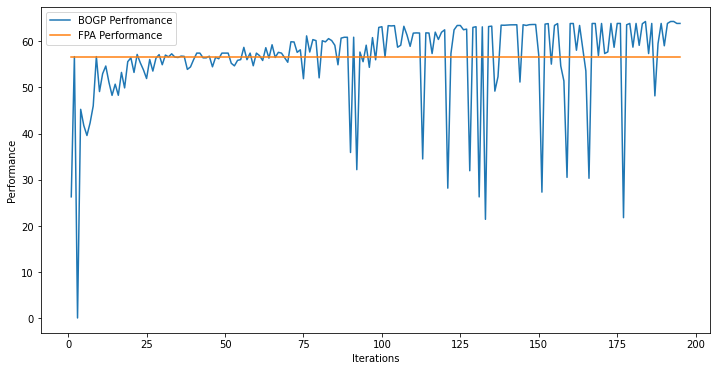

x_next is [ 35.86193048   7.49107581 -13.74188331  -4.79393758  16.14303561
 -19.6448057   13.83798347 -22.67368261 -29.47704986 -22.69493451
  29.65531656   0.34132395   8.22005459  16.49234279  18.57953982
   2.68479331  11.09102164   3.9794804   26.61144527 -27.11872839]
f()=56.209052, actual=26.545
45


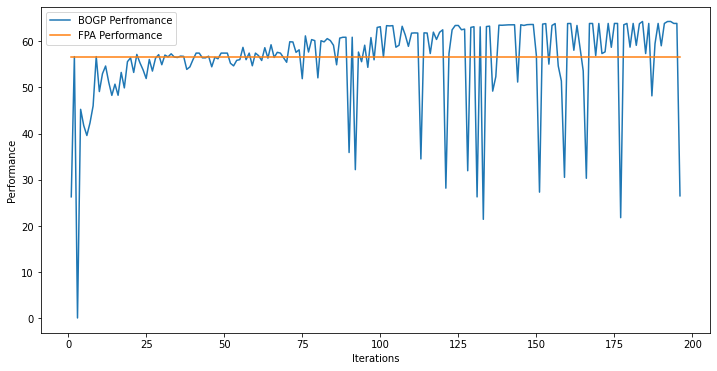

x_next is [ 23.23480616  36.97314705  34.94718299 -24.8931823   35.90179354
  35.98989347  13.02829431  23.40700335  10.69156647   6.3170561
  -0.5947294   36.15635352  16.46528839  26.20855995 -20.14516671
  21.01052288  -4.12796974  -9.79370719 -15.36086157 -16.29102548]
f()=56.057321, actual=35.630
46


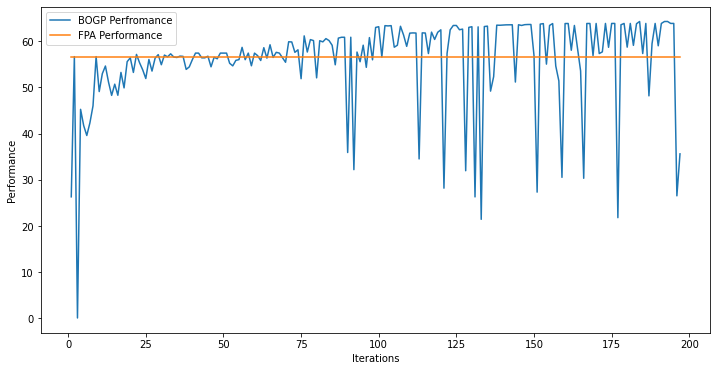

x_next is [ 39.99999591  -3.07328992  39.99999492  39.99999502  39.99982464
  39.999994    39.99999697  29.99833927  39.99991309  30.23054924
 -30.99996139 -30.99993903  39.99987592  39.99996687  39.99999325
  39.99999435  39.99999592  39.99999562  29.15096625  39.99991187]
f()=60.436037, actual=60.446
47


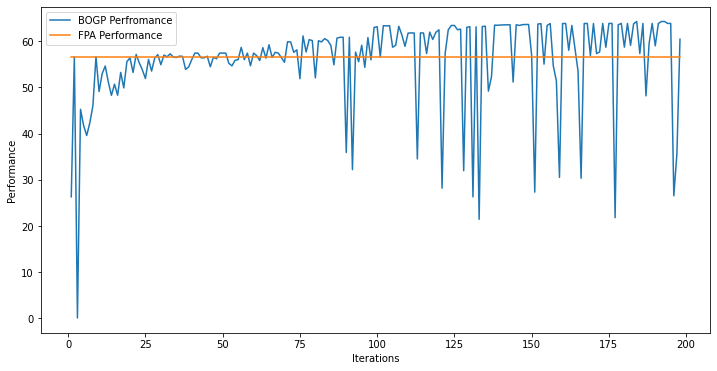

x_next is [ 27.42292655  30.05750191  32.91553409 -21.81536641  31.81075375
  29.16998741  23.2893042  -20.10634918  37.56006676  39.55021806
 -17.29958442  -0.44097895  32.79125205  35.21148127  -9.93607089
  -5.01271137  39.67586646  -7.01965752  -3.97311286 -24.30771194]
f()=55.976187, actual=30.012
48


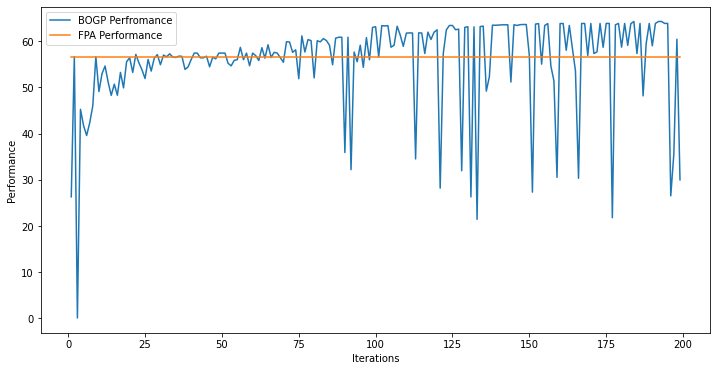

x_next is [ 39.99919504  -3.25607698  39.99988744  39.9996525   39.99998341
  39.99940938  39.99834952  30.07362148  39.99999036  29.99112926
 -30.99880908 -30.99998137  39.99980617  39.99990167  39.99910583
  39.99954089  39.99999452  39.9999885   29.97732433  39.99990486]
f()=60.449710, actual=60.414
49


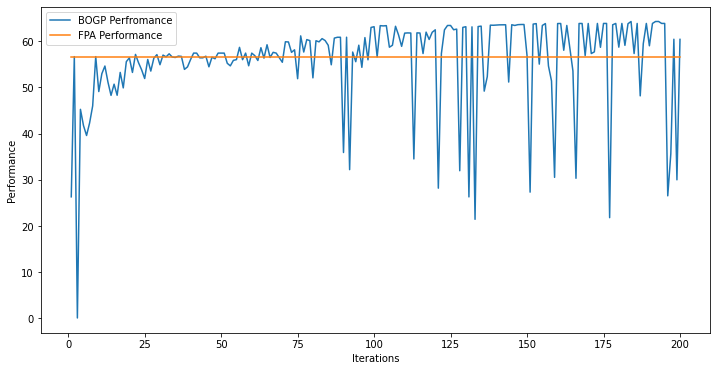

In [17]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

#X = 0 * np.ones([1,var], dtype = "float")
#y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

#tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
#y_FPA = np.array([[tr_FPA]])

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(50):
  x_next = opt_acquisition(X, y, model, X.shape[0]+1)

  np.save("/content/drive/MyDrive/trainingx_BOGP_P=40_3.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_P=40_3.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_P=40_3.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)
  
  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()


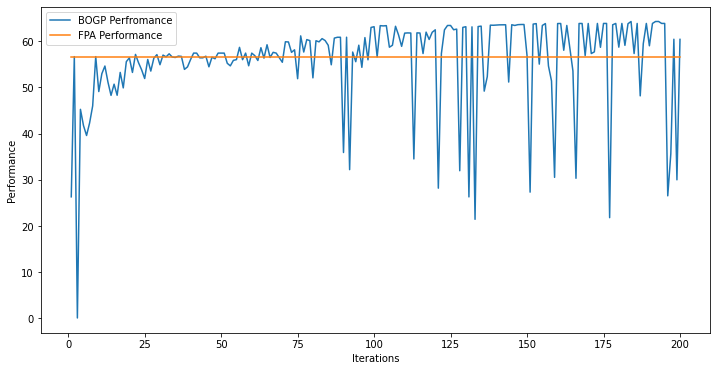

P_max = 40.000, Optimal_SE = 64.293
P_max = 40.000, Optimal_SE_FPA = 56.682


In [18]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

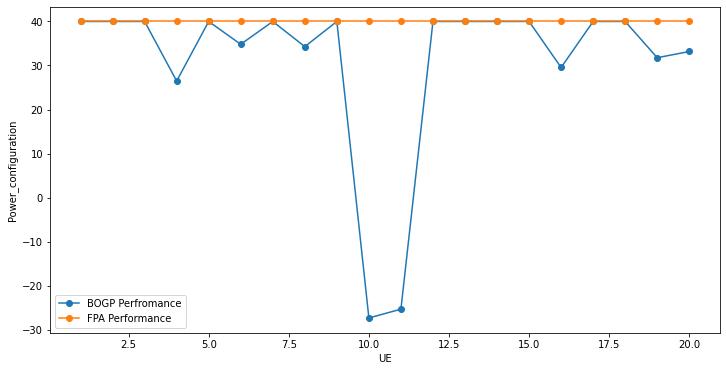

Power_configuration_BOGP is [ 39.99999999  40.          40.          26.47627808  40.
  34.81406396  40.          34.28647176  40.         -27.3374439
 -25.33363122  40.          40.          40.          40.
  29.54855941  40.          39.99884917  31.7677324   33.17967919]


In [19]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:], '-o')
pyplot.plot(np.arange(1,21),X_FPA[:], '-o')
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

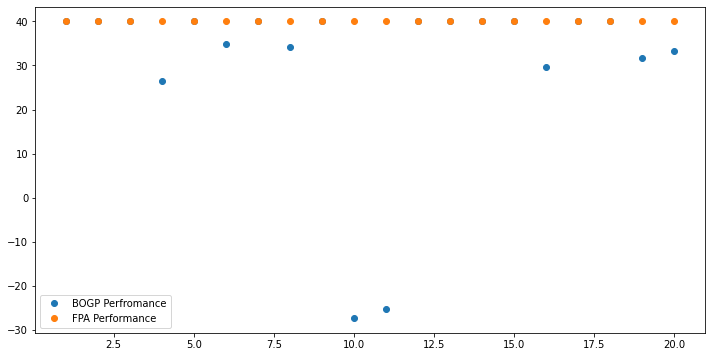

Power_configuration_BOGP is [ 39.99999999  40.          40.          26.47627808  40.
  34.81406396  40.          34.28647176  40.         -27.3374439
 -25.33363122  40.          40.          40.          40.
  29.54855941  40.          39.99884917  31.7677324   33.17967919]


In [20]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])